# Lily's physiological data analysis

This script:

1. loads in all the participant data
2. Cleans up the data accordingly i.e. renames columns etc. 
3. Plots the raw data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import savgol_filter
import os

In [2]:
path = "C:/Users/VR-Lab/Documents/Projects/LH_Project/Data/"

## 1. Load all participant data collected so far

In [3]:
files = os.listdir(path)

tmpDF = None
df = None

for file in files:
    if 'json' in file:
        tmpDF = pd.read_json(path+file)
        
        if df is None:
            df = tmpDF
        else:
            df = pd.concat((df, tmpDF))        
df.head(3)

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,541,39,0.291603,startNow,AC071320,1,1
1,476,77,0.301579,startNow,AC071320,1,1
2,419,115,0.311549,startNow,AC071320,1,1


## 2. Clean up the data 

### List phases present in the experiment

In [4]:
participants_to_update = df.loc[df['phase'] == 'calm_1o3', 'Participant_ID'].unique()

# Update "Condition" column to 0 for rows belonging to identified participants
for participant in participants_to_update:
    df.loc[df['Participant_ID'] == participant, 'Condition'] = 0
    
df.head(3)

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,541,39,0.291603,startNow,AC071320,1,1
1,476,77,0.301579,startNow,AC071320,1,1
2,419,115,0.311549,startNow,AC071320,1,1


### For ease of analysis, rename the stress and calm conditions to numbers

e.g.
stress_1o1 and calm_1o1 will become p1 and 
stress_1o2 and calm_1o2 will become p2 etc. 

We can afford to do this now because we separated out the conditions to 0 for calm and 1 for stress so we do not need the phases in order to tell which condition the participant experienced in the experiment

This will make plotting the figures simpler, i.e. instead of seeing 6 phases (3 for the calm plut 3 for the stress conditions) we now only see 3 phases in total and we use the condition parameter to separate out which is stress and which is calm

In [5]:
# Rename the conditions from numbers to words i.e. condition 0 = calm and condition 1 = stress 
df['Condition'] = df['Condition'].replace({0: 'Calm', 1: 'Stress'})
df['Condition'] = df['Condition'].replace({3: 'Stress'})

# Rename the 3 phases in the calm and stress conditions to phases 1 to 3
df['phase'] = df['phase'].replace({'calm_1o3': 'Phase_1', 'stress_1o3': 'Phase_1'})
df['phase'] = df['phase'].replace({'calm_2o3': 'Phase_2', 'stress_2o3': 'Phase_2'})
df['phase'] = df['phase'].replace({'calm_3o3': 'Phase_3', 'stress_3o3': 'Phase_3'})

# Rename calm or stress end phases to phase end 
df['phase'] = df['phase'].replace({'calm_end': 'Washout', 'stress_end': 'Washout'})

# Rename to baseline for the initial baseline part of the experiment
df['phase'] = df['phase'].replace({'end_instructions': 'Baseline'})


In [6]:
pd.unique(df['Condition'])

array(['Stress', 'Calm'], dtype=object)

In [7]:
pd.unique(df['phase'])

array(['startNow', 'start_experiment', 'buggy_journey',
       'fix_buggy_instructions', 'storm_instructions', 'Baseline',
       'Phase_1', 'Phase_2', 'Phase_3', 'Washout', 'experiment_end'],
      dtype=object)

### For the analysis, only use those phases that are relevant for your particular intervention and exclude the rest, which is what we are doing here

In [8]:
excludePhases = (df['phase']!='startNow') & (df['phase']!='start_experiment') & (df['phase']!='buggy_journey') & (df['phase']!='fix_buggy_instructions') & (df['phase']!='storm_instructions') & (df['phase']!='experiment_end')

## 3. Raw data plots

### Here use the above selected phases on your plots and for the analysis to filter the data 

#### For GSR we may need to normalise according to each participant's baseline values

In [9]:
# We took the inverse of the resistance to convert the values to conductance 
# df['gsr_response'] = 1/df['gsr_response']

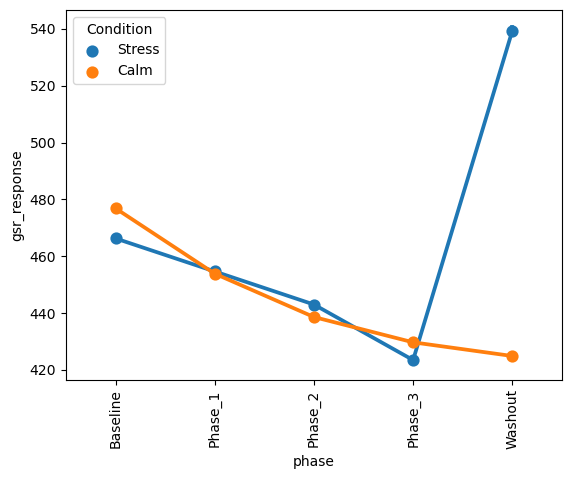

In [10]:
ax1 = sns.pointplot(x='phase',y='gsr_response', data=df[excludePhases], hue='Condition')
ax1.tick_params(axis='x', rotation=90)

In [11]:
### Heart rate 

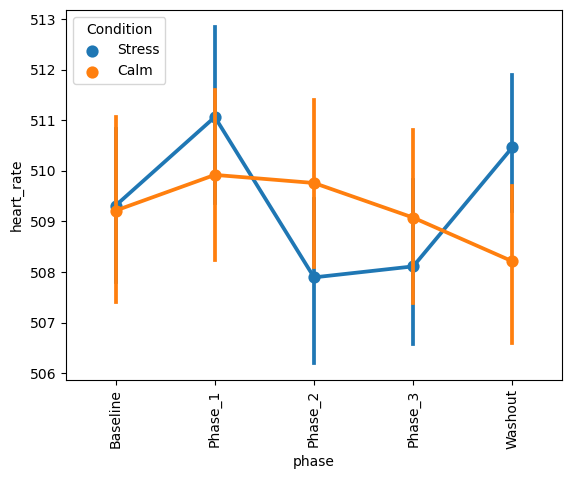

In [12]:
ax2 = sns.pointplot(x='phase', y='heart_rate', data=df[excludePhases], hue='Condition')
ax2.tick_params(axis='x', rotation=90)

## 4. Hear-Rate-Variability (HRV) Computation

In [61]:
df

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,541,39,0.291603,startNow,AC071320,Stress,1
1,476,77,0.301579,startNow,AC071320,Stress,1
2,419,115,0.311549,startNow,AC071320,Stress,1
3,368,153,0.322520,startNow,AC071320,Stress,1
4,344,190,0.333490,startNow,AC071320,Stress,1
...,...,...,...,...,...,...,...
33383,313,920,361.040845,experiment_end,YW151300,Calm,0
33384,302,918,361.050817,experiment_end,YW151300,Calm,0
33385,293,916,361.061789,experiment_end,YW151300,Calm,0
33386,277,914,361.072759,experiment_end,YW151300,Calm,0


Sampling Rate: 93.0 Hz
Heart Rate: 134 
Heart Rate Variability: 0.2977958152622873 


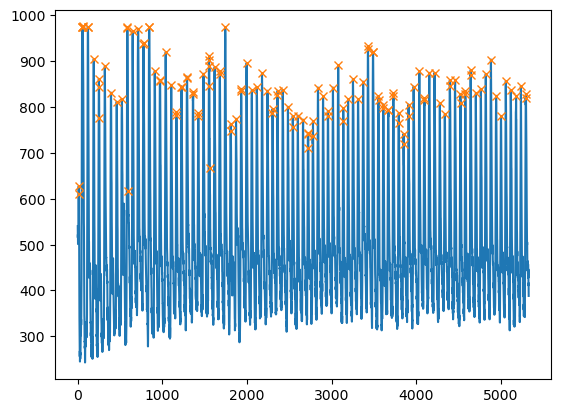

In [60]:
# Example trial from an example participant for testing and understanding HRV
ptxes = pd.unique(df['Participant_ID'])
testmask = (df['Participant_ID'] == 'yu191230') & (df['phase'] == 'Phase_1')

# Get the values into a new variable for ease of use 
vals = df[testmask]['heart_rate'].values

# Compute the sampling rate using time and number of samples 
trialDuration = df[testmask]['time'].values[-1] - df[testmask]['time'].values[0] # in seconds 
numbSamples = len(df[testmask]['time'].values)
sampleRate = np.round(numbSamples/trialDuration)
print("Sampling Rate: " + str(sampleRate) + " Hz")

# Find the peaks using an arbitrary height value, i.e. ignore all peaks below that value e.g. 600
pks,_ = find_peaks(vals,height=600)

heart_rate = len(pks)
hr_time_diff = np.diff(pks) * (1/sampleRate)
hr_variability = np.std(hr_time_diff)
print("Heart Rate: " + str(heart_rate) + " ")
print("Heart Rate Variability: " + str(hr_variability) + " ")

# Display plots of the heart rate and detected peaks 
plt.plot(vals)
plt.plot(pks, vals[pks],'x')

In [53]:
hr_time_diff * (1/sampleRate)

array([0.00034686, 0.0062435 , 0.00034686, 0.0062435 , 0.00034686,
       0.00693722, 0.0068216 , 0.0062435 , 0.00034686, 0.0062435 ,
       0.00693722, 0.0068216 , 0.00023124, 0.00659036, 0.00705284,
       0.0073997 , 0.00751532, 0.00659036, 0.00728408, 0.00716846,
       0.00034686, 0.00716846, 0.00670598, 0.00716846, 0.00716846,
       0.00693722, 0.00670598, 0.0073997 , 0.0073997 , 0.00693722,
       0.00693722, 0.00774656, 0.00751532, 0.0068216 , 0.0073997 ,
       0.00023124, 0.00705284, 0.00693722, 0.0068216 , 0.00728408,
       0.00716846, 0.00693722, 0.00693722, 0.00716846, 0.00670598,
       0.00023124, 0.0062435 , 0.00312175, 0.00381547, 0.00693722,
       0.00659036, 0.00023124, 0.00635912, 0.00034686, 0.00647474,
       0.00034686, 0.0068216 , 0.00693722, 0.00034686, 0.00034686,
       0.00161868, 0.00462481, 0.00034686, 0.0068216 , 0.00659036,
       0.00034686, 0.00693722, 0.00034686, 0.00023124, 0.00531853,
       0.00069372, 0.00023124, 0.00265927, 0.00034686, 0.00358

In [ ]:
# hr_time_diff = np.diff(peaks)
# hr_variability = np.std(hr_time_diff)

df['HRV'] = 

# print('Average HRV: ' + str(np.round(np.mean(hr_time_diff * (1/sampling_rate)),3)) + ' SD: ' + str(np.round(hr_variability * (1/sampling_rate),3)))

### Compute the Heart Rate Varibility (HRV) 
Use a window of a certain size (experiment with different window sizes) to compute this value

##### How to compute HRV is by taking the standard deviation of the HRV for comparisons

In [10]:
time = df['time'].values[-1] 
numb_per_samples = len(df['time'])

print("Duration: " + str(time))
print("Samples: " + str(numb_per_samples))

sampling_rate = numb_per_samples / time

print('Sampling rate: ' + str(np.round(sampling_rate)))

Duration: 388.923017
Samples: 35985
Sampling rate: 93.0


### Overall heart rate variability (HRV)

#### Dumb way of computing the HRV for the different conditions

In [21]:
# print(len(peaks)/5)

# baseline_start = peaks[50:177]
# condition_1 = peaks[178:177*2]
# condition_2 = peaks[2*177:177*3]
# condition_3 = peaks[3*177:177*4]
# baseline_end = peaks[4*177:177*5]


In [23]:
# plt.plot([0,1,2,3,4], [np.nanmean(np.diff(baseline_start)), 
#                       np.nanmean(np.diff(condition_1)),
#                       np.nanmean(np.diff(condition_2)),
#                       np.nanmean(np.diff(condition_3)),
#                       np.nanmean(np.diff(baseline_end)),], 'r-o')

In [24]:
# baseline_start_hr = len(peaks[50:177]) / (peaks[50:177] * (1/sampling_rate) * 60)
# condition_1_hr = len(peaks[178:177*2]) / (peaks[178:177*2] * (1/sampling_rate) * 60)
# condition_2_hr = len(peaks[2*177:177*3]) / (peaks[2*177:177*3] * (1/sampling_rate) * 60)
# condition_3_hr = len(peaks[3*177:177*4] ) / (peaks[3*177:177*4] * (1/sampling_rate) * 60)
# baseline_end_hr = len(peaks[4*177:177*5]) / (peaks[4*177:177*5] * (1/sampling_rate) * 60)

In [25]:
# plt.plot([0,1,2,3,4], [np.nanmean(np.diff(baseline_start_hr)), 
#                       np.nanmean(np.diff(condition_1_hr)),
#                       np.nanmean(np.diff(condition_2_hr)),
#                       np.nanmean(np.diff(condition_3_hr)),
#                       np.nanmean(np.diff(baseline_end_hr)),], 'r-o')

In [26]:
# hr_time_diff = np.diff(peaks)
# hr_variability = np.std(hr_time_diff)

# print('Average HRV: ' + str(np.round(np.mean(hr_time_diff * (1/sampling_rate)),3)) + ' SD: ' + str(np.round(hr_variability * (1/sampling_rate),3)))

In [ ]:
# df['HRV'] = hr_time_diff

### HRV Per condition 

In [27]:
# hr_time_diff = np.diff(peaks)
# hr_variability = np.std(hr_time_diff)

# print('Average HRV: ' + str(np.round(np.mean(hr_time_diff * (1/sampling_rate)),3)) + ' SD: ' + str(np.round(hr_variability * (1/sampling_rate),3)))